#import necessary libraries


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
from datetime import datetime
from distutils.util import strtobool
import pandas as pd
import os

In [3]:
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )

def create_df(data, frequency):
    print(data.head())  # Check the first few rows of the data

    colnames = data["type"].values
    datapoints = data["series_value"].values
    print(datapoints)  # Check if it contains valid data

    
    d = {}
    lens = []
    for col, val in zip(colnames, datapoints):
        d[col] = val
        lens.append(len(val))
        
    df = pd.DataFrame(d)
    max_len = max(lens)  # The maximum length of any series in the data
    print(lens)  # Ensure it's populated correctly
    print(max_len)  # Should be a positive integer
    start_time = min(data["start_timestamp"].values)
    
    # Ensure that the length of timestamps matches the number of rows in the DataFrame
    # Generate a timestamp range that matches the number of rows in the DataFrame
    timestamps = pd.date_range(start_time, periods=len(df), freq='1H', inclusive='left')
    
    # Add the 'timestamp' column to the DataFrame
    df["timestamp"] = timestamps
    
    return df


In [4]:
loaded_data,frequency, forecast_horizon, contain_missing_values, contain_equal_length  = convert_tsf_to_dataframe("vehicle_trips_dataset_with_missing_values.tsf")
loaded_data

,series_name,base_number,base_name,type,start_timestamp,series_value
0,T1,B00013,LOVE CORP CAR INC,trips,2015-01-01,"[26.0, 79.0, 62.0, 76.0, 292.0, 414.0, 412.0, ..."
1,T2,B00014,NY ONE CORP CAR INC,trips,2015-01-01,"[45.0, 110.0, 126.0, 108.0, 441.0, 593.0, 638...."
2,T3,B00029,COMMUNITY CAR SVC CORP,trips,2015-01-01,"[731.0, NaN, NaN, NaN, NaN, NaN, 814.0, 918.0,..."
3,T4,B00053,CHARGE AND RIDE INC,trips,2015-01-01,"[10.0, 26.0, 21.0, 16.0, 72.0, 94.0, 117.0, 11..."
4,T5,B00095,LIBERTY CAR SERVICE INC.,trips,2015-01-01,"[814.0, 830.0, NaN, 733.0, 399.0, 420.0, 447.0..."
...,...,...,...,...,...,...
324,T325,B01653,ART'S PLACE INC.,vehicles,2015-05-01,"[11.0, 9.0, 12.0, 13.0, 10.0, 11.0, 12.0, 12.0..."
325,T326,B01808,OLD TOWN CARS CORP,vehicles,2015-05-01,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10...."
326,T327,B02574,"MTC LIMOUSINE & CORPORATE COACH,INC.",vehicles,2015-05-01,"[38.0, 20.0, 40.0, 46.0, 41.0, 42.0, 47.0, 45...."
327,T328,B02611,SS LIMOUSINE SERVICE INC,vehicles,2015-05-02,"[6.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, ..."


In [5]:
df = create_df(loaded_data,1)
df.to_csv("vehicle_trips.csv",index=False)
df = pd.DataFrame()
df.head()

  series_name base_number                 base_name   type start_timestamp  \
0          T1      B00013         LOVE CORP CAR INC  trips      2015-01-01   
1          T2      B00014       NY ONE CORP CAR INC  trips      2015-01-01   
2          T3      B00029    COMMUNITY CAR SVC CORP  trips      2015-01-01   
3          T4      B00053       CHARGE AND RIDE INC  trips      2015-01-01   
4          T5      B00095  LIBERTY CAR SERVICE INC.  trips      2015-01-01   

                                        series_value  
0  [26.0, 79.0, 62.0, 76.0, 292.0, 414.0, 412.0, ...  
1  [45.0, 110.0, 126.0, 108.0, 441.0, 593.0, 638....  
2  [731.0, NaN, NaN, NaN, NaN, NaN, 814.0, 918.0,...  
3  [10.0, 26.0, 21.0, 16.0, 72.0, 94.0, 117.0, 11...  
4  [814.0, 830.0, NaN, 733.0, 399.0, 420.0, 447.0...  
[<NumpyExtensionArray>
 [ 26.0,  79.0,  62.0,  76.0, 292.0, 414.0, 412.0, 484.0, 326.0, 117.0,
  ...
  496.0, 453.0, 275.0,  76.0, 124.0, 338.0, 442.0, 433.0, 456.0, 245.0]
 Length: 212, dtype: object


/tmp/ipykernel_19446/3973716040.py:167: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start_time, periods=len(df), freq='1H', inclusive='left')


""


In [6]:
df = pd.read_csv('vehicle_trips_dataset_with_missing_values.tsf', sep='\t')
df

,# Dataset Information
0,# This dataset contains 329 daily time series ...
1,# The dataset was extracted from https://githu...
2,#
3,"# For more details, please refer to"
4,"# fivethirtyeight, 2015. uber-tlc-foil-respons..."
...,...
340,T325:B01653:ART'S PLACE INC.:vehicles:2015-05-...
341,T326:B01808:OLD TOWN CARS CORP:vehicles:2015-0...
342,"T327:B02574:MTC LIMOUSINE & CORPORATE COACH,IN..."
343,T328:B02611:SS LIMOUSINE SERVICE INC:vehicles:...


In [7]:
import pandas as pd

# Replace 'your_file.tsf' with the actual path to your TSF file
df = pd.read_csv('vehicle_trips_dataset_with_missing_values.tsf', sep='\t',header=None,encoding='utf-8')
df.head()


,0
0,# Dataset Information
1,# This dataset contains 329 daily time series ...
2,# The dataset was extracted from https://githu...
3,#
4,"# For more details, please refer to"


In [8]:
df.tail()

,0
341,T325:B01653:ART'S PLACE INC.:vehicles:2015-05-...
342,T326:B01808:OLD TOWN CARS CORP:vehicles:2015-0...
343,"T327:B02574:MTC LIMOUSINE & CORPORATE COACH,IN..."
344,T328:B02611:SS LIMOUSINE SERVICE INC:vehicles:...
345,"T329:B01818:TA-TA TRANSPORTATION, INC.:vehicle..."


#load dataset

In [10]:
# Load the data
df = pd.read_csv('fulfilment_center_info.csv')
df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


#basic info

In [11]:
df.columns

Index(['center_id', 'city_code', 'region_code', 'center_type', 'op_area'], dtype='object')

In [12]:
df.tail()

,center_id,city_code,region_code,center_type,op_area
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1
76,51,638,56,TYPE_A,7.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [14]:
df.size

385

In [15]:
df.shape

(77, 5)

In [16]:
df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [17]:
df.columns

Index(['center_id', 'city_code', 'region_code', 'center_type', 'op_area'], dtype='object')

In [18]:
df.dropna(axis=1, inplace=True)

In [19]:
df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

#splitting

In [20]:
# Encode categorical variables
df['center_type'] = df['center_type'].map({'TYPE_A': 0, 'TYPE_B': 1, 'TYPE_C': 2})

In [21]:
# Define features (X) and target variable (y)
X = df[['city_code', 'region_code', 'center_type']]
y = df['op_area']

In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50, random_state=42)


In [23]:
from sklearn.ensemble import RandomForestRegressor
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [24]:
y_train_pred= rf_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f'Training MSE: {mse_train:.2f}')


Training MSE: 0.21


In [25]:
y_pred_test= rf_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'Testing MSE: {mse_test:.2f}')


Testing MSE: 1.03


In [26]:
# Create a DataFrame with target and predicted values
results_df = pd.DataFrame({
    'Target Values': np.concatenate((y_train, y_test)),
    'Predicted Values': np.concatenate((y_train_pred, y_pred_test))
})

# Save the DataFrame to a CSV file
results_df.to_csv('target_and_predicted_values.csv', index=False)
results_df.head()

,Target Values,Predicted Values
0,2.8,3.073000
1,4.4,4.267558
2,7.0,6.765819
3,3.5,3.876355
4,3.8,2.863050


In [30]:
# Forecasting for the next 5 time steps
forecasting_horizon = 10

# Get the last values of the features
last_city_code = X.iloc[:, 0].max()
last_region_code = X.iloc[:, 1].max()
last_center_type = X.iloc[:, 2].max()

forecasted_values = []
for i in range(forecasting_horizon):
    # Create a new data point with the last values of the features and increment the city code
    new_data_point = np.array([[last_city_code + i + 1, last_region_code, last_center_type]])

    # Use the trained model to make a prediction on the new data point
    forecasted_value = rf_model.predict(new_data_point)

    # Append the forecasted value to the list
    forecasted_values.append(forecasted_value[0])



/home/b1987/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/b1987/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/b1987/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/b1987/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/b1987/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor wa

In [31]:
print("Forecasted values for the next {} time steps:".format(forecasting_horizon))
print(forecasted_values)

Forecasted values for the next 10 time steps:
[np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006), np.float64(3.8450000000000006)]


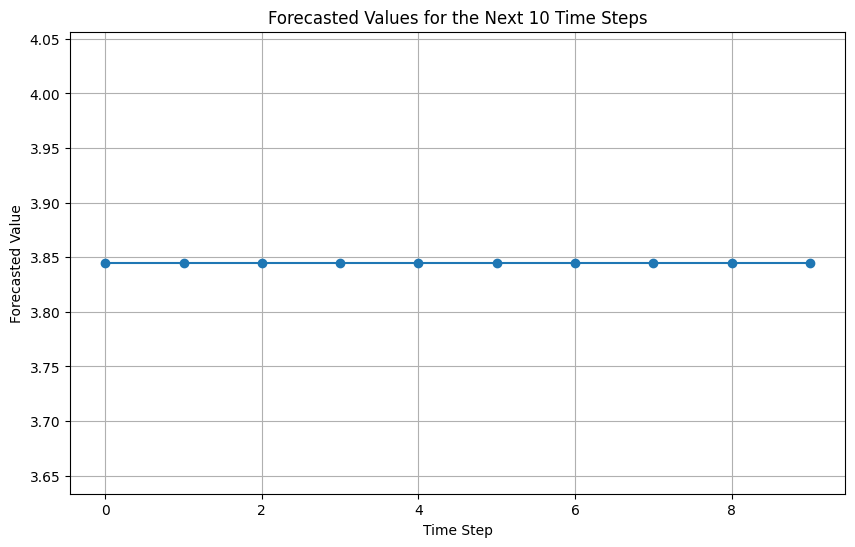

In [32]:
import matplotlib.pyplot as plt

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(forecasted_values, marker='o')
plt.title("Forecasted Values for the Next {} Time Steps".format(forecasting_horizon))
plt.xlabel("Time Step")
plt.ylabel("Forecasted Value")
plt.grid(True)
plt.show()